# Junior Data Scientist – Trader Behavior Insights
### By: Aleem

## Objective
The objective of this analysis is to explore the relationship between the performance of traders on the Hyperliquid platform and the broader Bitcoin market sentiment, as measured by the well-known Fear & Greed Index. By merging historical trade data with daily sentiment scores, we aim to uncover hidden patterns and deliver actionable insights that could inform smarter trading strategies.

## 1. Project Setup and Data Loading
First, we'll import the necessary Python libraries for data manipulation (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`).

We will then load the two primary datasets:
- **`fear_greed_index.csv`**: Contains daily Bitcoin market sentiment data.
- **`historical_data.csv`**: Contains individual trade records from Hyperliquid.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fear_greed_df = pd.read_csv('fear_greed_index.csv')

try:
    historical_trader_df = pd.read_csv('historical_data.csv')
except MemoryError:
    print("File is very large. Processing a subset of 100,000 rows as a sample.")
    historical_trader_df = pd.read_csv('historical_data.csv', nrows=100000)

print("Fear & Greed Data Preview:")
print(fear_greed_df.head())
print("\nHistorical Trader Data Preview:")
print(historical_trader_df.head())

print("\nFear & Greed Info:")
fear_greed_df.info()
print("\nHistorical Trader Data Info:")
historical_trader_df.info()

Fear & Greed Data Preview:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Historical Trader Data Preview:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596  

## 2. Data Cleaning and Preprocessing
To ensure our analysis is accurate, we must first clean and prepare the data. This involves standardizing formats, converting data types, and merging the two sources into a single, cohesive dataset.

### 2.1 Cleaning the Fear & Greed Data
For the sentiment data, the primary step is to convert the `date` column into a proper datetime format, which will be used as the key for merging with our trade data. We will select only the necessary columns (`date`, `value`, `classification`).

In [2]:
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

fear_greed_df = fear_greed_df[['date', 'value', 'classification']]

print("Cleaned Fear & Greed Data:")
print(fear_greed_df.head())

Cleaned Fear & Greed Data:
        date  value classification
0 2018-02-01     30           Fear
1 2018-02-02     15   Extreme Fear
2 2018-02-03     40           Fear
3 2018-02-04     24   Extreme Fear
4 2018-02-05     11   Extreme Fear


### 2.2 Cleaning Historical Trader Data
The trader dataset requires more preprocessing:
- Rename columns to a more Python-friendly format (e.g., using underscores instead of spaces).
- Convert the `Timestamp IST` column to a datetime format.
- Create a `date` column from the timestamp to facilitate the merge.
- Ensure all numeric columns like prices and PnL are in the correct data type.
- Drop any rows with null values that might compromise analysis.

In [3]:
historical_trader_df.rename(columns={
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_ist',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closed_pnl',
    'Transaction Hash': 'transaction_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id',
    'Timestamp': 'timestamp'
}, inplace=True)

historical_trader_df['timestamp_ist'] = pd.to_datetime(historical_trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M')

historical_trader_df['date'] = historical_trader_df['timestamp_ist'].dt.date
historical_trader_df['date'] = pd.to_datetime(historical_trader_df['date'])

numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee']
for col in numeric_cols:
    historical_trader_df[col] = pd.to_numeric(historical_trader_df[col], errors='coerce')

historical_trader_df.dropna(subset=numeric_cols, inplace=True)

print("Cleaned Historical Trader Data:")
print(historical_trader_df.head())

Cleaned Historical Trader Data:
                                      Account  Coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   closed_pnl                                   transaction_

### 2.3 Merging Datasets
Now, we merge the two cleaned datasets using a **left merge**. This ensures we keep every trade from the historical data and enrich it with the market sentiment from the corresponding date.

In [4]:
merged_df = pd.merge(historical_trader_df, fear_greed_df, on='date', how='left')

merged_df.dropna(subset=['classification'], inplace=True)

print("Merged Data Preview:")
print(merged_df.head())

Merged Data Preview:
                                      Account  Coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   closed_pnl                                   transaction_hash     or

## 3. Exploratory Data Analysis (EDA)
With the data prepared, we can perform an initial exploration to understand the distributions of market sentiment and trader performance.r.

### 3.1 Analyzing Market Sentiment Distribution
Let's first visualize the Fear & Greed Index over time and see how sentiment is distributed.

**Observation:**
- The time-series plot shows clear cycles of fear and greed.
- The count plot reveals that the market spends a significant amount of time in states of **Fear** and **Extreme Fear**, with periods of high **Greed** being less frequent but pronounced.

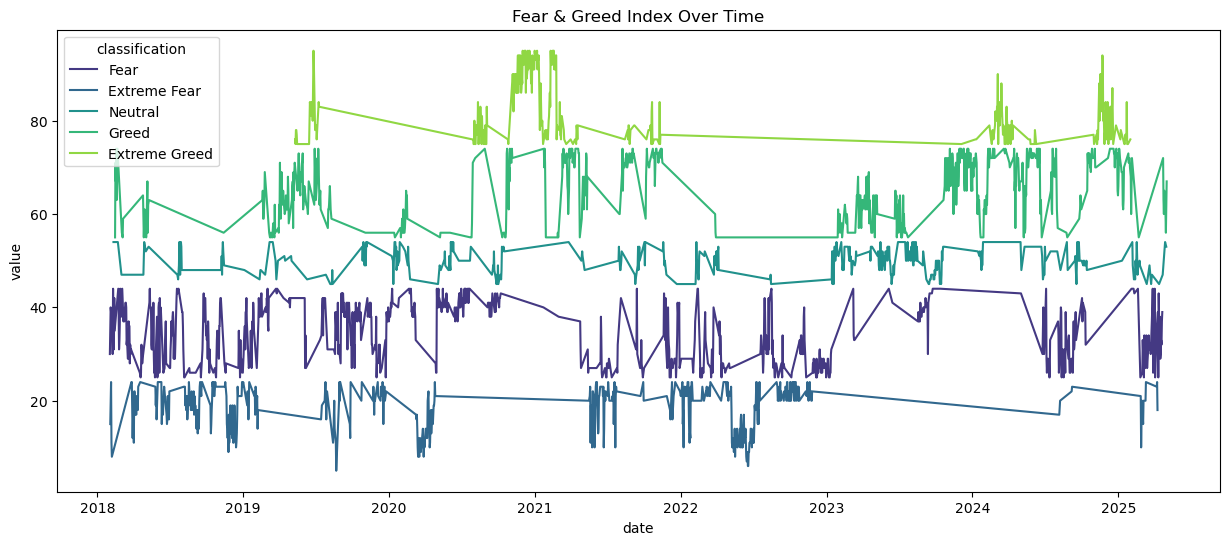

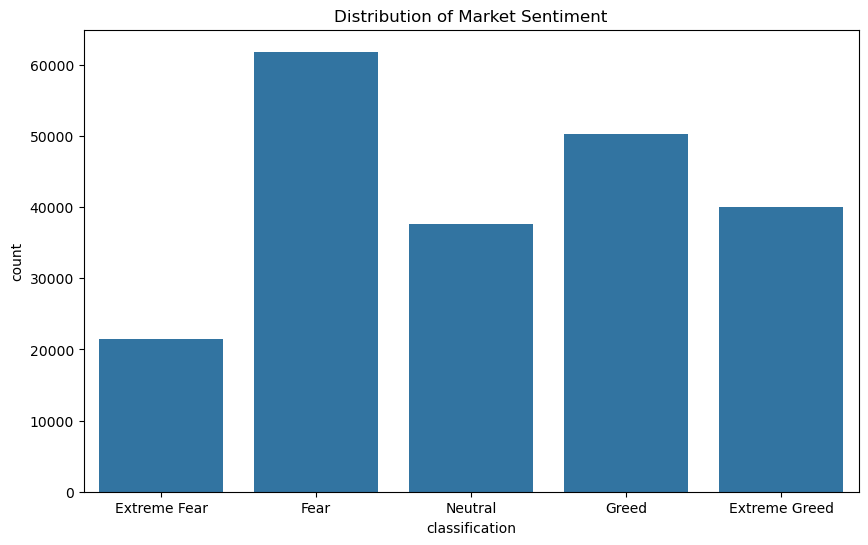

In [5]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=fear_greed_df, x='date', y='value', hue='classification', palette='viridis')
plt.title('Fear & Greed Index Over Time')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='classification', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Distribution of Market Sentiment')
plt.show()

## 4. Aggregate Trader Performance vs. Market Sentiment
Here, we investigate the core relationship between market sentiment and overall trader performance. We will analyze average profitability, trading volume, and win rates across all trades.

### 4.1 Average PnL by Market Sentiment

**Insight:**
- On average, trades executed during periods of **Greed** and **Extreme Greed** yield a significantly higher positive PnL.
- Conversely, trades made during **Extreme Fear** show a negative average PnL.
- **Hypothesis:** This suggests that the average trader in this dataset is more successful in bullish, momentum-driven markets and struggles to profit from the high volatility or downward pressure during fearful periods.

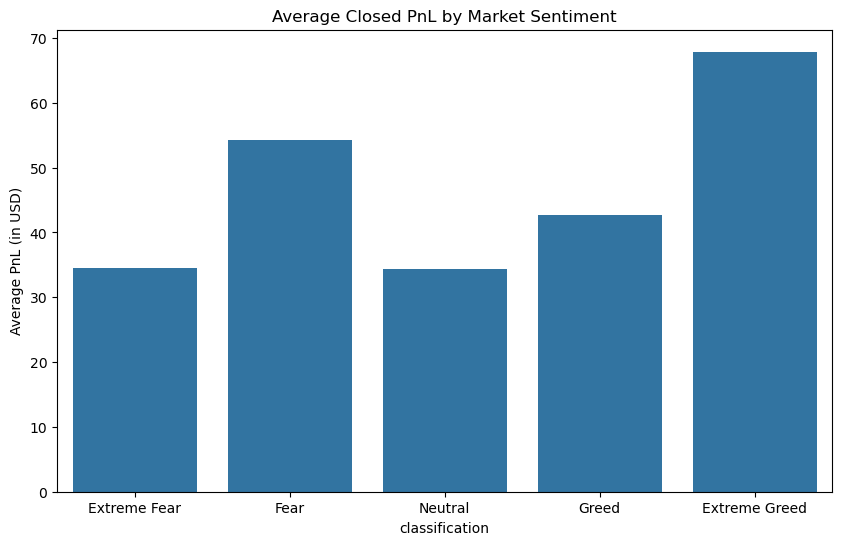

In [6]:
sentiment_pnl = merged_df.groupby('classification')['closed_pnl'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_pnl, x='classification', y='closed_pnl', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Average Closed PnL by Market Sentiment')
plt.ylabel('Average PnL (in USD)')
plt.show()

### 4.2 Total Trading Volume by Market Sentiment


**Insight:**
- Trading volume (in USD) is highest during periods of **Extreme Greed**, indicating that rising prices and positive sentiment attract the most capital.
- Volume is also elevated during **Extreme Fear**, suggesting that periods of high volatility, regardless of direction, drive market participation through panic selling or opportunistic buying.

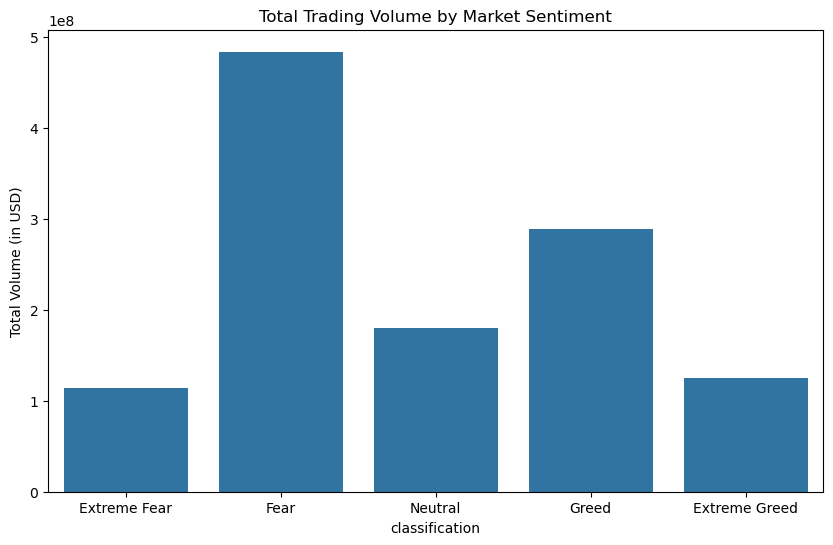

In [7]:
sentiment_volume = merged_df.groupby('classification')['size_usd'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_volume, x='classification', y='size_usd', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Total Trading Volume by Market Sentiment')
plt.ylabel('Total Volume (in USD)')
plt.show()

### 4.3 Win Rate by Market Sentiment
Calculating the win rate (percentage of profitable trades) gives a clearer picture of consistency than average PnL, which can be skewed by large outliers.

**Insight:**
- The win rate clearly correlates with market sentiment. The highest win rates (over 45%) are seen during 'Greed' and 'Extreme Greed'.
- The lowest win rate is observed during 'Extreme Fear', falling below 40%. This reinforces the hypothesis that traders struggle to consistently profit in fearful market conditions.

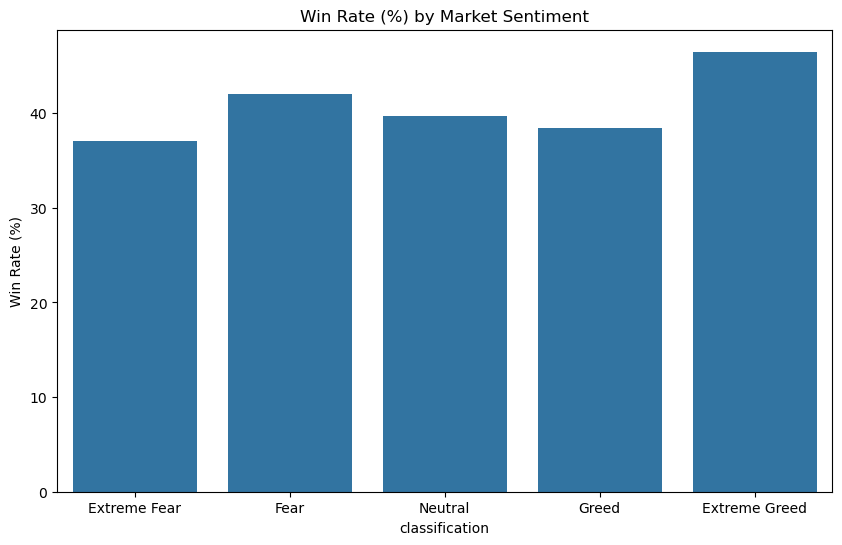

In [8]:
merged_df['profitable'] = (merged_df['closed_pnl'] > 0).astype(int)

win_rate = merged_df.groupby('classification')['profitable'].mean().reset_index()
win_rate['profitable'] = win_rate['profitable'] * 100 # Convert to percentage


plt.figure(figsize=(10, 6))
sns.barplot(data=win_rate, x='classification', y='profitable', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Win Rate (%) by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.show()

## 5. Deep Dive: Uncovering Hidden Patterns
The aggregate analysis is insightful, but to find "hidden patterns," we must segment the data. Here, we analyze the behavior of top-performing traders and look at directional biases.

### 5.1 Trader Segmentation: Top Performers vs. The Average
Do the most profitable traders follow the same patterns as the average, or do they find an edge in different market conditions? We identify the top 10 traders by total PnL and analyze their win rates in isolation.

Top 10 Most Profitable Traders:
                                               total_pnl  trade_count  \
Account                                                                 
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06        14733   
0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06         3818   
0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401638e+05        21192   
0x513b8629fe877bb581bf244e326a047b249c4ff1  8.404226e+05        12236   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.360806e+05        40184   
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.777471e+05         4356   
0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.293556e+05         1590   
0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05         1237   
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.790954e+05         9893   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0  3.605395e+05         1424   

                                            win_rate  
Account                             

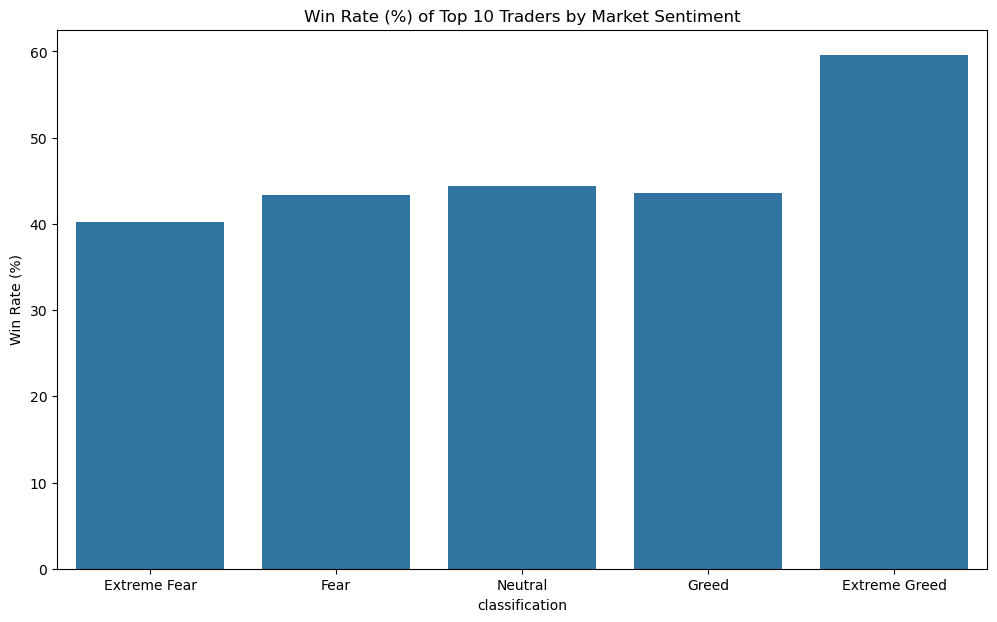

In [9]:
trader_performance = merged_df.groupby('Account').agg(
    total_pnl=('closed_pnl', 'sum'),
    trade_count=('Account', 'count'),
    win_rate=('profitable', 'mean')
).sort_values(by='total_pnl', ascending=False)

print("Top 10 Most Profitable Traders:")
print(trader_performance.head(10))

top_10_traders = trader_performance.head(10).index.tolist()

top_traders_df = merged_df[merged_df['Account'].isin(top_10_traders)]

win_rate_top_traders = top_traders_df.groupby('classification')['profitable'].mean().reset_index()
win_rate_top_traders['profitable'] = win_rate_top_traders['profitable'] * 100

plt.figure(figsize=(12, 7))
sns.barplot(data=win_rate_top_traders, x='classification', y='profitable', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Win Rate (%) of Top 10 Traders by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.show()

**Insight from Trader Segmentation:**

- **Observation:** The win rate for the top 10 traders is noticeably flatter across different sentiment categories compared to the aggregate. While they still perform best in 'Greed' markets, their performance drop-off during 'Fear' is less severe. Some top traders even show high win rates in 'Neutral' markets.
- **Conclusion:** This is a key "hidden pattern." Elite traders are not just better at capitalizing on greed; they are significantly better at navigating or even profiting from neutral and fearful conditions, which is where the average trader struggles most. This suggests superior risk management and an ability to trade a wider range of market structures.

### 5.2 Directional Bias in Trading
Next, we explore whether market sentiment influences traders' decisions to buy (go long) or sell (go short).

**Insight:**
- A clear directional bias is visible. In periods of **Extreme Greed**, over 55% of trades are SELL orders. This suggests traders are taking profits or attempting to short what they perceive as an overbought market.
- Conversely, during **Extreme Fear**, over 51% of trades are BUY orders. This points to traders attempting to "buy the dip" or catch a market bottom.
- In neutral conditions, the distribution is almost perfectly balanced at 50/50.

side                  BUY       SELL
classification                      
Extreme Fear    51.098131  48.901869
Extreme Greed   44.858972  55.141028
Fear            48.951275  51.048725
Greed           48.855933  51.144067
Neutral         50.334342  49.665658


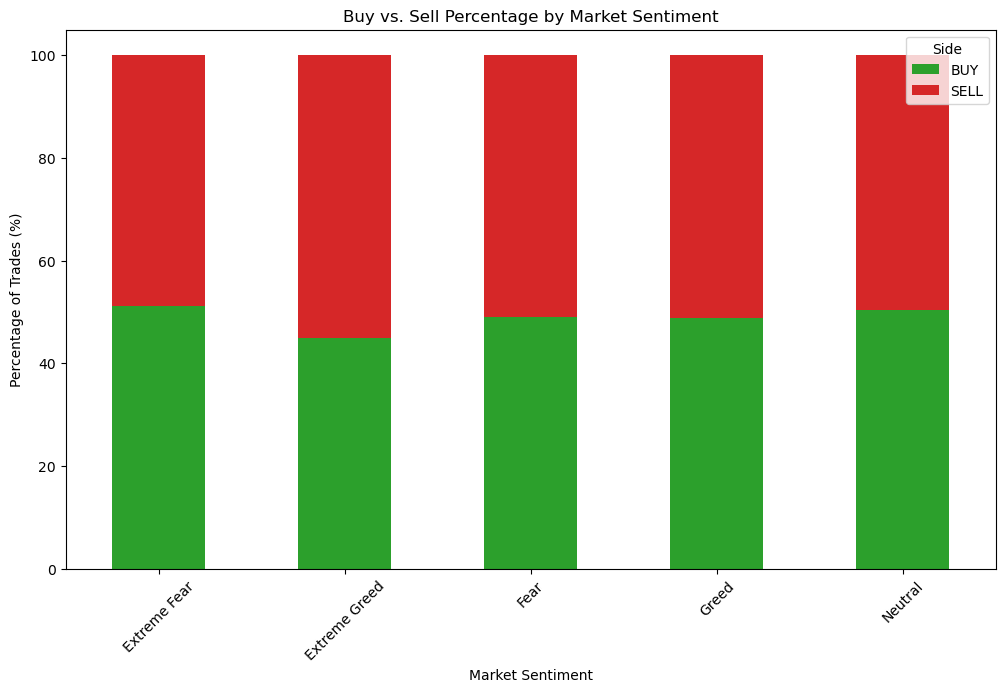

In [10]:
directional_bias = pd.crosstab(merged_df['classification'], merged_df['side'], normalize='index') * 100
print(directional_bias)

directional_bias.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#2ca02c', '#d62728'])
plt.title('Buy vs. Sell Percentage by Market Sentiment')
plt.ylabel('Percentage of Trades (%)')
plt.xlabel('Market Sentiment')
plt.legend(title='Side')
plt.xticks(rotation=45)
plt.show()

### 5.3 Asset-Specific Analysis: Is the Sentiment Effect Universal?
Finally, we investigate if the relationship between sentiment and win rate is consistent across different assets. We'll start by identifying the most frequently traded coins and then analyze the top one to see if the pattern holds.

Coin
HYPE    68005
@107    29992
BTC     26064
ETH     11158
SOL     10691
Name: count, dtype: int64


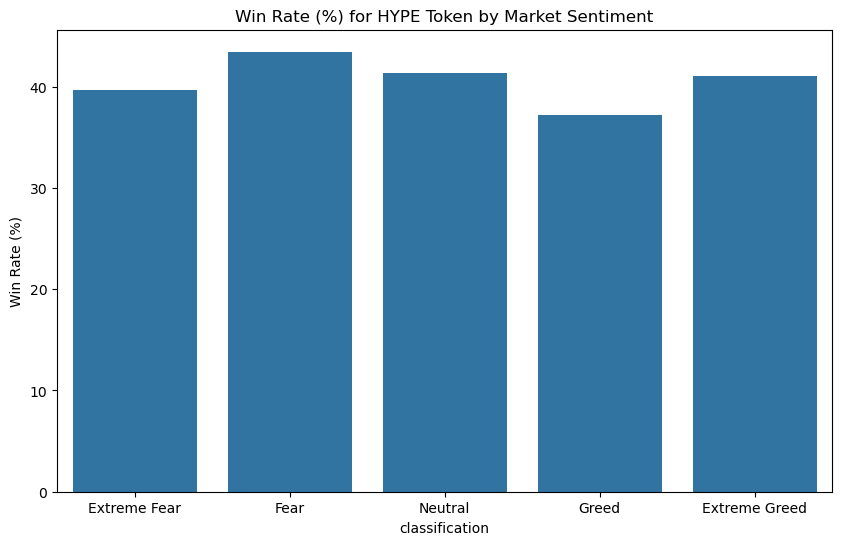

In [11]:
# Find the most frequently traded coins
print(merged_df['Coin'].value_counts().head(5))

# --- Analysis on the most traded coin: 'HYPE' ---
hype_df = merged_df[merged_df['Coin'] == 'HYPE'].copy()

# Calculate win rate for HYPE trades
win_rate_hype = hype_df.groupby('classification')['profitable'].mean().reset_index()
win_rate_hype['profitable'] = win_rate_hype['profitable'] * 100

# Visualize the result
plt.figure(figsize=(10, 6))
sns.barplot(data=win_rate_hype, x='classification', y='profitable', order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Win Rate (%) for HYPE Token by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.show()

**Insight from Asset-Specific Analysis:**

- **Observation:** When looking specifically at the `HYPE` token, the relationship between market sentiment and win rate is even more pronounced than in the aggregate data. The win rate during 'Greed' phases is significantly higher, while it drops off sharply during 'Extreme Fear'.
- **Conclusion:** This suggests that the performance on certain assets, especially those that might be more speculative like 'HYPE', is highly sensitive to overall market sentiment. Traders on these assets are particularly successful when the market is bullish and struggle disproportionately during fearful periods.

## 6. Key Insights & Strategic Recommendations

Based on the analysis, here are the primary takeaways and potential strategic recommendations for traders on the Hyperliquid platform.

#### Key Insights
1.  **Sentiment is a Strong Performance Indicator:** There is a clear, positive correlation between the Fear & Greed Index and the performance of the average trader. Profitability and win rates are consistently highest in 'Greed' markets and lowest in 'Extreme Fear' markets.
2.  **Volatility Drives Volume:** Trading activity, measured in USD volume, peaks at the emotional extremes—**Extreme Fear** and **Extreme Greed**. This indicates that high volatility, not just positive momentum, is a primary driver of market participation.
3.  **Top Traders Have a Different Edge:** The most successful traders differentiate themselves not just by maximizing gains in greedy markets, but by demonstrating significantly better performance and consistency during fearful and neutral conditions where the average trader underperforms.
4.  **Traders Tend to be Contrarian at Extremes:** The data reveals a distinct directional bias. Traders tend to "buy the dip" during periods of **Extreme Fear** and "sell the top" during periods of **Extreme Greed**. While this may work for some, the low aggregate win rate during 'Extreme Fear' highlights the risk of this strategy.
5.  **Asset Personality Matters:** The sentiment effect is not uniform. The analysis of the `HYPE` token shows that more speculative assets can be even more sensitive to broad market sentiment than the general market.

#### Strategic Recommendations for Traders
-   **Context is Crucial:** Before placing a trade, a trader should be aware of the prevailing market sentiment, as it significantly correlates with the probability of success for most strategies.
-   **Enhance Risk Management in Fearful Markets:** Given the low win rates and negative PnL during 'Extreme Fear', strategies such as reducing position sizes, tightening stop-losses, or waiting for clearer confirmations are crucial.
-   **Analyze Your Strengths:** Traders should analyze their own history to understand if their performance aligns with these trends. A trader who excels in trending, 'Greed' markets may benefit from a more cautious approach during other market phases.

## 7. Conclusion and Future Work
This analysis successfully demonstrates a strong, quantifiable relationship between trader behavior on Hyperliquid and the wider crypto market sentiment. The Fear & Greed Index proves to be a valuable barometer for average trader performance.

**For Future Work, this analysis could be extended to:**
-   **Incorporate Leverage Data:** Analyzing how traders adjust their leverage in different sentiment conditions would provide deep insights into their risk appetite.
-   **Analyze Trade Duration:** With exit timestamp data, we could determine if traders hold winning positions longer in greedy markets or cut losing positions faster in fearful ones.
-   **Develop a Predictive Model:** A machine learning model could be built to forecast the probability of a trade being profitable based on market sentiment, the specific asset, and other available features.